# Training a neural network from scratch

Formulas from https://udlbook.com.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load data

In [2]:
train_X = np.load("data/train_images.npy") / 255
train_y = np.load("data/train_labels.npy").astype(int).flatten()

print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")

train_X.shape: (60000, 784)
train_y.shape: (60000,)


## Utility functions

ReLU, softmax

In [3]:
def ReLU(x):
    return np.clip(x, 0, None)

In [4]:
def softmax(z):
    """
    Takes in an ndarray (..., ..., N) and applies softmax
        along the last dimension.
    """
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=-1, keepdims=True)

# Do a sense check
print(softmax(np.array([
    [1, 2, 3, 4],
    [1, 0, 0, 0],
    [10, -100, -100, -100],
    [0, 0, 0, 0]
])))

[[3.20586033e-02 8.71443187e-02 2.36882818e-01 6.43914260e-01]
 [4.75366886e-01 1.74877705e-01 1.74877705e-01 1.74877705e-01]
 [1.00000000e+00 1.68891188e-48 1.68891188e-48 1.68891188e-48]
 [2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01]]


## Implement the model

In [97]:
class ArrayWithMomentum:
    """
    Ingests gradient vectors / matrices and spits out updated values.
    """

    def __init__(self, arr, beta, gamma, epsilon=1e-8):
        self.arr = arr
        self.arr_sq = np.power(arr, 2)
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.t = 0

    def update(self, new_arr):
        self.arr = self.beta * self.arr + (1 - self.beta) * new_arr
        self.arr_sq = self.gamma * self.arr_sq + (1 - self.gamma) * np.power(new_arr, 2)
        self.t += 1

    def get(self):
        m = self.arr / (1 - np.power(self.beta, self.t + 1))
        v = self.arr_sq / (1 - np.power(self.gamma, self.t + 1))
        return m / (np.sqrt(v) + self.epsilon)

In [98]:
class Layer:
    """
    Represents a layer in a deep neural network and its incoming weights.
    Takes in an ndarray as input and returns outputs.
    Has utilities for computing gradients etc.
    """
    def __init__(self, in_size, out_size, act_func="relu"):
        """
        in_size: number of input nodes
        out_size: number of output nodes
        act_func: activation function (string)
        Use He initialization for weights.
        """
        self.weights = np.random.normal(
            loc=0,
            scale=np.sqrt(4 / (in_size + out_size)),
            size=(out_size, in_size)
        )
        self.biases = np.zeros(out_size)
        self.act_func = act_func.lower()

        # Store values for forward pass
        self.in_acts = None
        self.out_acts = None

        self.weights_update = ArrayWithMomentum(np.zeros_like(self.weights), 0.9, 0.999, 1e-8)
        self.biases_update = ArrayWithMomentum(np.zeros_like(self.biases), 0.9, 0.999, 1e-8)

    def __call__(self, inputs):
        """
        Feed forward.
        inputs.shape: (batch_size, in_size)
        """
        self.in_acts = inputs[:]
        
        # Terrible hack to account for matrix order being weird
        self.out_preacts = (self.weights @ inputs.T).T

        # Add biases
        self.out_preacts += np.broadcast_to(self.biases, self.out_preacts.shape)

        # Apply the activation function
        if self.act_func == "relu":
            self.out_acts = ReLU(self.out_preacts)
        else:
            self.out_acts = self.out_preacts
        return self.out_acts
    
    def compute_grads(self, out_preacts_grad):
        """
        Compute the gradients of weights, biases, and input activations (nodes)
            given gradient of output pre-activations.
        Assumes self.in_acts, self.out_preacts, and self.out_acts are all defined
            and have shape (batch_size, ...)

        out_preacts_grad: gradients of output activations
            shape: (batch_size, N_nodes)
        """
        # numpy.matmul documentation:
        # https://numpy.org/doc/stable/reference/generated/numpy.matmul
        self.biases_grad = out_preacts_grad[:]
        self.weights_grad = out_preacts_grad[:,:,None] @ self.in_acts[:,None,:]
        
        in_preacts_grad = (self.in_acts > 1e-5) * (self.weights.T @ out_preacts_grad.T).T

        # Return gradients of previous layer's pre-activations
        # shape: (batch_size, N_nodes_prev_layer)
        return in_preacts_grad
    
    def update_params(self):
        """
        Update parameters with SGD and Adam.
        """
        self.weights_update.update(np.mean(self.weights_grad, axis=0))
        self.biases_update.update(np.mean(self.biases_grad, axis=0))

        self.biases -= self.biases_update.get() * alpha
        self.weights -= self.weights_update.get() * alpha

In [99]:
def cross_entropy_loss(outputs, y_true, from_logits=True):
    """
    Computes the average loss across these examples.
    outputs has shape (N, out_size)
    y_true has shape (out_size)
    """
    if from_logits:
        out_probs = softmax(outputs)
    else:
        out_probs = outputs

    # Terrible hack to select only the outputs we care about
    # https://stackoverflow.com/questions/70664524/numpy-use-all-rows-in-multidimensional-integer-indexing

    if len(out_probs.shape) == 1:
        assert np.issubdtype(y_true, int), "Output and label dimensions are incompatible."
        return -np.log(out_probs[y_true])

    return -np.sum(np.log(np.take_along_axis(out_probs, y_true[:,None], 1))) / len(y_true)

In [100]:
class Network:
    def __init__(self, in_size, out_size, hidden_sizes):
        """
        Initialize the deep network.
        If params is defined, it should have this structure:
            [
                (weights_0, biases_0),
                (weights_1, biases_1),
                ...
                (weights_(n_layers-1), biases_(k-1))
            ]
        """
        self.layers = []
        self.layers.append(Layer(in_size, hidden_sizes[0]))
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(Layer(hidden_sizes[i], hidden_sizes[i+1]))
        self.layers.append(Layer(hidden_sizes[-1], out_size))

    def __call__(self, inputs):
        """
        inputs must have shape (batch_size, in_size)
        Returns the output logits (pre-normalization outputs)
        """
        cur = inputs
        for layer in self.layers:
            cur = layer(cur)
        return cur
    
    def loss(self, X, y):
        return cross_entropy_loss(self.__call__(X), y, from_logits=True)
    
    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

    def predict(self, inputs):
        """
        Runs the inputs through the model, but argmax-es the last layer.
        """
        outputs = self.__call__(inputs)
        return np.argmax(outputs, axis=1)
    
    def compute_grads(self, X, y):
        """
        Compute gradients through all layers of the network.
        Should always be preceded by Network.__call__(X)

        X: inputs, of shape (batch_size, n_features)
        y: outputs, of shape (batch_size,)
        """
        batch_size, _ = X.shape

        outputs = self.__call__(X)  # shape: (batch_size, 10)
        exp = np.exp(outputs)       # shape: (batch_size, 10)
        sum_exp = np.sum(exp, axis=1)

        label_mask = np.zeros_like(exp, dtype=bool)
        label_mask[np.arange(batch_size),y] = True

        label_outputs = exp[np.arange(batch_size),y]  # Get (batch_size,) array of ONLY label outputs
        outputs_grad = np.zeros_like(exp)
        outputs_grad -= (label_mask * exp) * (sum_exp - label_outputs)[:,None]
        outputs_grad += (~label_mask * exp) * label_outputs[:,None]
        outputs_grad /= (sum_exp**2)[:,None]

        cur_preact_grad = self.layers[-1].compute_grads(outputs_grad)
        for i in range(len(self.layers) - 2, -1, -1):
            cur_preact_grad = self.layers[i].compute_grads(cur_preact_grad)
    
    def update_params(self, alpha=1e-3):
        for layer in self.layers:
            layer.update_params(alpha)

In [122]:
nn = Network(784, 10, [128, 64])
print(f"prediction on first example:")
print(nn(train_X[:1]))

print(f"Initial loss: {nn.loss(train_X, train_y):.5f}")
print(f"Initial accuracy: {nn.accuracy(train_X, train_y):.5f}")

prediction on first example:
[[0.         1.66415604 0.19383365 0.         0.         0.
  0.         0.         0.29107943 0.        ]]
Initial loss: 2.56843
Initial accuracy: 0.11015


In [123]:
def training_epoch(train_X, train_y, lr=1e-3, batch_size=30):
    loss_history = []

    pbar = tqdm(range(len(train_X) // batch_size))
    for batch_idx in pbar:
        X = train_X[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        y = train_y[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        nn.compute_grads(X, y)
        nn.update_params(alpha=lr)

        loss = nn.loss(X, y)
        loss_history.append(loss)
        pbar.set_description(f"loss: {loss:.4f}")
        
    return loss_history

In [124]:
def train_iteration(epochs, lr, batch_size):
    all_loss_history = []
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        all_loss_history.extend(training_epoch(train_X, train_y, lr=lr, batch_size=batch_size))
        loss_history.append(all_loss_history[-1])
        accuracy = nn.accuracy(train_X, train_y)
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch:<2}: loss={loss_history[-1]:.5f}, accuracy={accuracy:.5f}")
    
    return loss_history, accuracy_history, all_loss_history

In [125]:
LOSS_HIST = []
ACC_HIST = []

In [130]:
(
    loss_history,
    accuracy_history,
    all_loss_history
) = train_iteration(epochs=1, lr=1e-6, batch_size=100)

LOSS_HIST.extend(all_loss_history)
ACC_HIST.extend(accuracy_history)

loss: 0.6693: 100%|██████████| 600/600 [00:29<00:00, 20.55it/s]


Epoch 0 : loss=0.66930, accuracy=0.79300


Text(0, 0.5, 'Training accuracy')

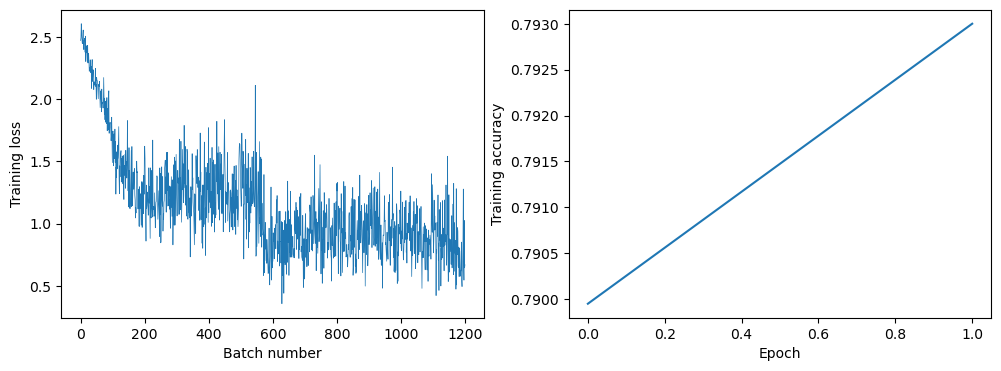

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(LOSS_HIST, label="Training loss", linewidth=0.5)
axs[0].set_xlabel("Batch number")
axs[0].set_ylabel("Training loss")
axs[1].plot(ACC_HIST, label="Training accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Training accuracy")

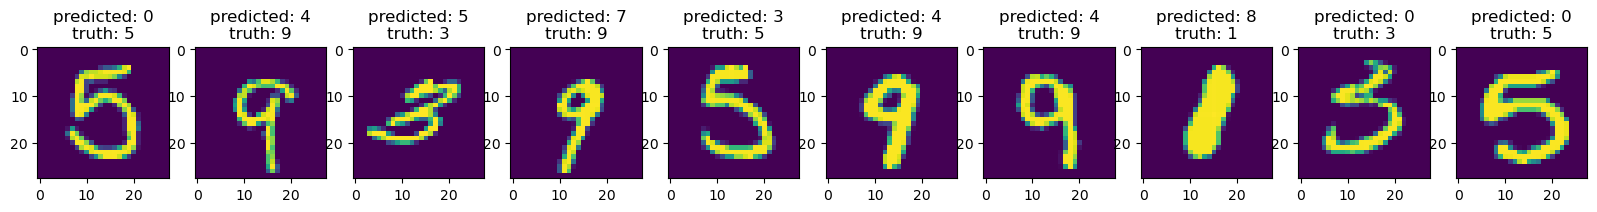

In [134]:
# Look at misidentified digits
y_pred = nn.predict(train_X)
wrong_indices = np.where(y_pred != train_y)[0]

def display_digit(img, title, ax):
    img = img.reshape((28, 28))
    ax.imshow(img)
    ax.set_title(title)

fig, axs = plt.subplots(1, 10, figsize=(20, 4))

np.random.shuffle(wrong_indices)
for i in range(10):
    idx = wrong_indices[i]
    display_digit(train_X[idx], f"predicted: {y_pred[idx]}\ntruth: {train_y[idx]}", axs[i])

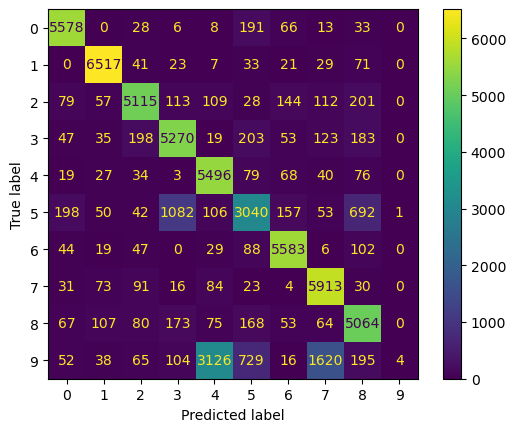

In [135]:
conf_mat = confusion_matrix(train_y, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(conf_mat);
disp.plot();